In [2]:
!pip install librosa
!pip install keras

  Using cached librosa-0.8.1-py3-none-any.whl (203 kB)
  Using cached SoundFile-0.10.3.post1-py2.py3.cp26.cp27.cp32.cp33.cp34.cp35.cp36.pp27.pp32.pp33-none-macosx_10_5_x86_64.macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.whl (613 kB)
  Using cached resampy-0.2.2.tar.gz (323 kB)
  Using cached audioread-2.1.9.tar.gz (377 kB)
     |████████████████████████████████| 57 kB 367 kB/s eta 0:00:01
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23141 sha256=60dccfb6bea655c1c492d0285cd6fe8f00a27f6a16f56f5930f73f7bcc0dd9ba
  Stored in directory: /Users/vpapadop/Library/Caches/pip/wheels/49/5a/e4/df590783499a992a88de6c0898991d1167453a3196d0d1eeb7
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320718 sha256=04d7ed288256bcd15a6b44080dbd734b66671efe6987015154744d066f2698dc
  Stored in directory: /Users/vpapadop/Library/Caches/pip/wheels/6f/d1/5d/f13da53b1dcbc2624ff548456c9ffb526c914f53c12c318bb4
Successfully built audioread resampy


In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle



In [2]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

In [26]:
df = pd.DataFrame(raw)
# df = df[:100]
print(df.shape)
df.head()

(2787, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


In [27]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (1950, 2), Test set size (837, 2)


True

In [28]:
def extract_mfcc(clip, nr_mfcc):
    signal ,sr = librosa.load(clip, duration=2, sr=16000) # downsample all clips to 16KHz
    mfcc_feature = librosa.feature.mfcc(signal, n_mfcc=nr_mfcc, sr=sr)
#     delta_feature = librosa.feature.delta(mfcc_feature)

#     mfcc_feature = np.mean(mfcc_feature.T,axis=0)
#     delta_feature = np.mean(delta_feature.T, axis=0)

    return pd.Series([mfcc_feature])

In [29]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [30]:
df_train.head()

,speaker,path,mfcc
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[[-213.70421, -237.9038, -284.6906, -301.7012,..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[[-512.8857, -503.47943, -500.7269, -499.65027..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[[-220.15564, -214.11272, -203.63281, -177.429..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[[-179.14407, -162.45625, -135.95302, -101.067..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[[-213.19301, -205.75508, -202.07959, -199.764..."


In [31]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,2]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
# np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=21)

print(X_train.shape)
x_train = np.hstack((X_train.to_list()))
x_train = x_train.reshape((X_train.shape[0],n_mfcc,n_mfcc))

x_test = np.hstack((X_test.to_list()))
x_test = x_test.reshape((X_test.shape[0],n_mfcc,n_mfcc))

# y_test = np.hstack((Y_test.to_list()))
# y_test = y_test.reshape((y_test.shape[0],n_mfcc,n_mfcc))
# print(y_test.shape)

print(f'Train set size: {x_train.shape}, Validation set size {x_test.shape}')

Number of speakers is 20
<class 'sklearn.preprocessing._label.LabelEncoder'>
(1365,)


ValueError: cannot reshape array of size 1117935 into shape (1365,13,13)

In [20]:
import keras
from keras import layers

In [30]:
original_dim = 32 * 32
intermediate_dim = 256
latent_dim = 128

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [31]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/50
8/8 [==============================] - 1s 50ms/step - loss: 691.8755 - val_loss: 664.5682
Epoch 2/50
8/8 [==============================] - 0s 30ms/step - loss: 625.0811 - val_loss: 549.9483
Epoch 3/50
8/8 [==============================] - 0s 28ms/step - loss: 422.5046 - val_loss: 218.9756
Epoch 4/50
8/8 [==============================] - 0s 28ms/step - loss: 95.3696 - val_loss: 11.7396
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 5.4081 - val_loss: 3.2002
Epoch 6/50
8/8 [==============================] - 0s 28ms/step - loss: 3.3716 - val_loss: 3.5889
Epoch 7/50
8/8 [==============================] - 0s 27ms/step - loss: 3.6811 - val_loss: 3.7495
Epoch 8/50
8/8 [==============================] - 0s 28ms/step - loss: 3.7474 - val_loss: 3.7234
Epoch 9/50
8/8 [==============================] - 0s 28ms/step - loss: 3.6835 - val_loss: 3.6254
Epoch 10/50
8/8 [==============================] - 0s 28ms/step - loss: 3.5738 - val_loss: 3.5055
Epoch 11/50
8/8

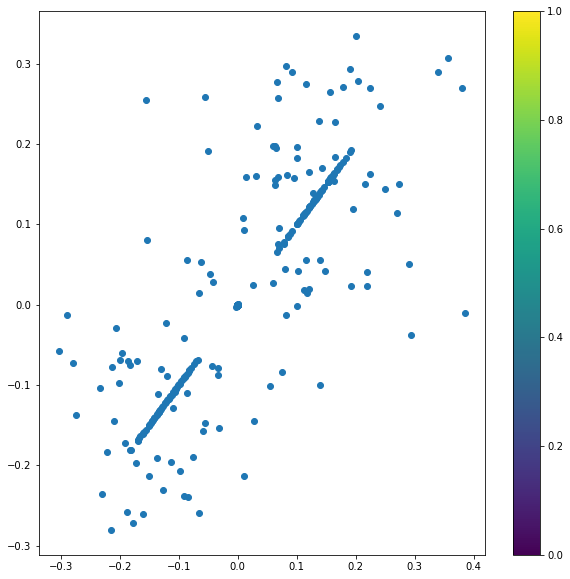

In [32]:
x_test_encoded = encoder.predict(x_test, batch_size=64)
x_test_encoded = np.array(x_test_encoded)

plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.colorbar()
plt.show()

In [303]:
x_test_encoded.shape


(3, 105, 2)

In [329]:
np.unique(Y_test[0:24])

array([0, 1, 2, 3, 4, 5])